In [ ]:
!git clone https://github.com/SenticNet/stress-detection

Cloning into 'stress-detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 2.88 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
import pandas as pd

# Use pd.read_excel to read Excel files
df = pd.read_excel("/content/stress-detection/Twitter_Full.xlsx")
print(df.head(10))

                                                text  \
0  Being s mom is cleaning 24/7 the same shit ove...   
1  And now we have been given the walkthru book b...   
2  Wishing YOU Peace Joy & Love! JoyTrain MentalH...   
3   speak-no-evil monkey Can I Be Honest With You...   
4  Psy Do u hv any regrets? Me No Psy Are you hap...   
5   police car light New Product Alert! police ca...   
6  Ordered my 2nd Ribble 20 years after the 1st o...   
7  Starting the day with a cleanse. Hot water wit...   
8  Welcoming September fallen leaf leaf flutterin...   
9  SamsungGalaxy zflip3 5G 128Go Here on Amazon p...   

                                            hashtags  labels  
0                       ['momlife', 'kids', 'tired']       1  
1                                       ['walkthru']       0  
2  ['Peace', 'Joy', 'Love', 'JoyTrain', 'MentalHe...       0  
3  ['therapy', 'help', 'NLP', 'CBT', 'hypnotherap...       1  
4                                                 []       0  
5    

In [ ]:
print(df.isnull().sum())

text        0
hashtags    8
labels      0
dtype: int64


In [ ]:
!pip install pandas numpy matplotlib seaborn wordcloud textblob vaderSentiment transformers

In [ ]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text

# Apply cleaning to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display cleaned text
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  Being s mom is cleaning 24/7 the same shit ove...   
1  And now we have been given the walkthru book b...   
2  Wishing YOU Peace Joy & Love! JoyTrain MentalH...   
3   speak-no-evil monkey Can I Be Honest With You...   
4  Psy Do u hv any regrets? Me No Psy Are you hap...   

                                        cleaned_text  
0  being s mom is cleaning 247 the same shit over...  
1  and now we have been given the walkthru book b...  
2  wishing you peace joy  love joytrain mentalhea...  
3  speaknoevil monkey can i be honest with you gl...  
4  psy do u hv any regrets me no psy are you happ...  


In [ ]:
#1: VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    return score
    #return 'positive' if score >= 0 else 'negative'  # Map score to label

df['vader_prediction'] = df['cleaned_text'].apply(get_vader_sentiment)

In [ ]:
#2: TextBlob
from textblob import TextBlob

def get_textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    return score
    #return 'positive' if score >= 0 else 'negative'  # Map score to label

df['textblob_prediction'] = df['cleaned_text'].apply(get_textblob_sentiment)

In [ ]:
df["labels"] = df["labels"].map({0: "positive", 1: "negative"})

In [ ]:
from sklearn.metrics import accuracy_score

# VADER Accuracy
vader_accuracy = accuracy_score(df['labels'], df['vader_prediction'])
print(f"VADER Accuracy: {vader_accuracy * 100:.2f}%")

# TextBlob Accuracy
textblob_accuracy = accuracy_score(df['labels'], df['textblob_prediction'])
print(f"TextBlob Accuracy: {textblob_accuracy * 100:.2f}%")


VADER Accuracy: 72.03%
TextBlob Accuracy: 62.97%


'# Hugging Face Transformers Accuracy\nhuggingface_accuracy = accuracy_score(df[\'label\'], df[\'huggingface_prediction\'])\nprint(f"Hugging Face Accuracy: {huggingface_accuracy * 100:.2f}%")'

In [ ]:
results = {
    'Model': ['VADER', 'TextBlob', 'Hugging Face'],
    'Accuracy': [vader_accuracy, textblob_accuracy, huggingface_accuracy]
}
results_df = pd.DataFrame(results)

print(results_df)

In [ ]:
def map_sentiment_to_stress(sentiment_score):
    if sentiment_score < -0.5:
        return "High Stress"
    elif -0.5 <= sentiment_score < 0.5:
        return "Moderate Stress"
    else:
        return "Low Stress"

df['stress_level'] = df['vader_prediction'].apply(map_sentiment_to_stress)

# Display stress levels
print(df[['cleaned_text', 'vader_prediction', 'stress_level']].head())

                                        cleaned_text  vader_prediction  \
0  being s mom is cleaning 247 the same shit over...           -0.8402   
1  and now we have been given the walkthru book b...            0.5994   
2  wishing you peace joy  love joytrain mentalhea...            0.9246   
3  speaknoevil monkey can i be honest with you gl...            0.2732   
4  psy do u hv any regrets me no psy are you happ...            0.9217   

      stress_level  
0      High Stress  
1       Low Stress  
2       Low Stress  
3  Moderate Stress  
4       Low Stress  


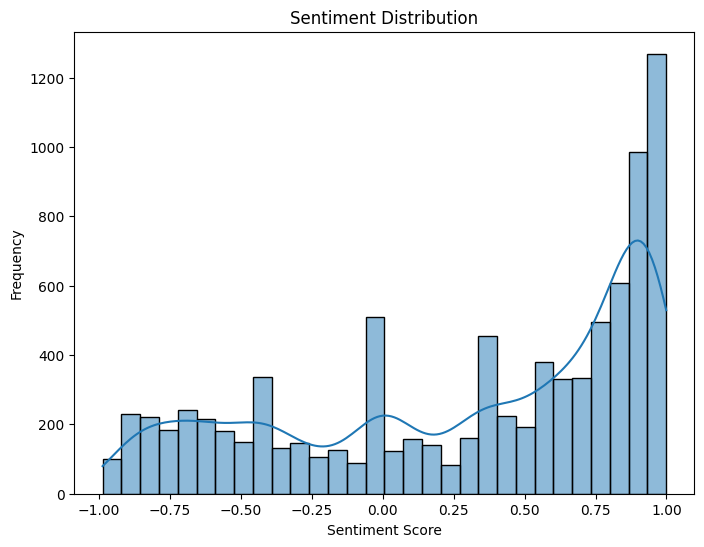

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['vader_prediction'], bins=30, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

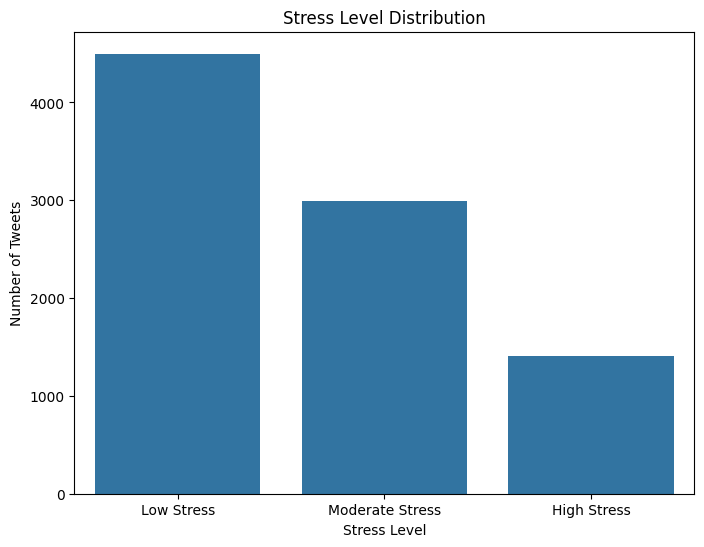

In [ ]:
# Plot stress level distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='stress_level', data=df, order=["Low Stress", "Moderate Stress", "High Stress"])
plt.title('Stress Level Distribution')
plt.xlabel('Stress Level')
plt.ylabel('Number of Tweets')
plt.show()

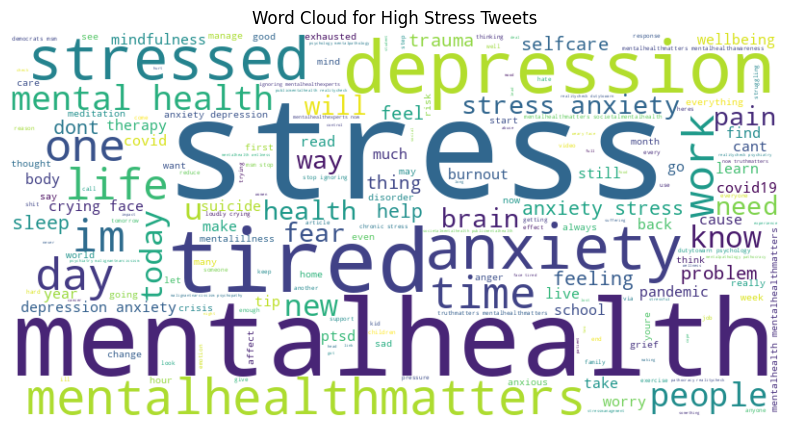

In [ ]:
from wordcloud import WordCloud

# Combine all high-stress tweets
high_stress_text = " ".join(df[df['stress_level'] == "High Stress"]['cleaned_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_stress_text)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Stress Tweets')
plt.show()

In [ ]:
df.to_csv('analyzed_stress_data.csv', index=False)

In [ ]:
'''#3: Hugging Face Transformers
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

def get_huggingface_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label'].lower()  # Ensure labels are lowercase

df['huggingface_prediction'] = df['cleaned_text'].apply(get_huggingface_sentiment)'''



'''# Hugging Face Transformers Accuracy
huggingface_accuracy = accuracy_score(df['label'], df['huggingface_prediction'])
print(f"Hugging Face Accuracy: {huggingface_accuracy * 100:.2f}%")'''